# Why you cannot predict market move with vanilla ML
This work illusturates a simple supervised setting where a ML model predicts the next market move given the current state. It seems pretty easy but nah :). 
What we do here surmises two things;
 
 - All information describing the market is hidden under the price values.
 - We go Semi-Markovian, meaning each prediction only depends on the present state.

Ok run everthing and plot the final graph on which you see the predictions at the last excerpt of the test set. 

From the first sight, everyhing seems perfect. Very good accuracy - better than random or predicting the frequent class always-. However, once you inspect the plot, you see that our model is tend to predict the move at time t as memorizing the on at time t-1. Which is quite natural and it gives a pretty good accuracy. It is a good catch for Kaggler but not for a trader.

Neverthless, the thing important for us to catch unexpected changes and we can already do what the model does here by eye seing. So this model unfortunately is not useful for real-life case. 

There are many tutorials on web tutoring market prediction following a similar pipeline depicted here, just measuring the success based on accuracy t. I try to illustrate here that they are far from reality and be aware. Best!!

Data is downloaded from https://www.kaggle.com/mczielinski/bitcoin-historical-data/data

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import finance as fin
from utils.utils11 import (dateparse, compute_features, 
                           compute_labels, cm_analysis,
                           model_performance, read_data,
                           check_labels)
import datetime
import time
import os

/home/eightbit/miniconda3/envs/dl/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [3]:
DATA_PATH = "../data/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv.csv"
df = read_data(DATA_PATH, 3) 

df_feats = compute_features(df)
df_feats.dropna(inplace=True)
df_feats

 > There are 486359 rows


,timestamp,high,low,close,wprice,open,CN,WC,HO,LO,CO,WO
3,1417412160,300.000000,300.000000,300.000000,300.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,1417412340,300.000000,300.000000,300.000000,300.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,1417412520,300.000000,300.000000,300.000000,300.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,1417412700,300.000000,300.000000,300.000000,300.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,1417412880,300.000000,300.000000,300.000000,300.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18,1417413060,300.000000,300.000000,300.000000,300.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21,1417413240,300.000000,300.000000,300.000000,300.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24,1417413420,300.000000,300.000000,300.000000,300.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
27,1417413600,300.000000,300.000000,300.000000,300.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30,1417413780,300.000000,300.000000,300.000000,300.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
# Validation split
train_split_point = time.mktime(datetime.datetime.strptime('2016-1-1 00:00:00', "%Y-%m-%d %H:%M:%S").timetuple())
split_point = time.mktime(datetime.datetime.strptime('2017-7-1 00:00:00', "%Y-%m-%d %H:%M:%S").timetuple())

df_train = df_feats[np.logical_and(df_feats['timestamp'] <  split_point, df_feats['timestamp'] > train_split_point)]
df_test = df_feats[df_feats['timestamp'] >  split_point]

print(df_train.shape)
print(df_test.shape)

(262541, 12)
(53319, 12)


In [6]:
y_train, label_names = compute_labels(df_train)
y_test, _ = compute_labels(df_test)

check_labels(y_test.argmax(axis=1), df_test['close'].values)
check_labels(y_train.argmax(axis=1), df_train['close'].values)

assert y_train.shape[0] == df_train.shape[0]
assert y_test.shape[0] == df_test.shape[0]

X_train = df_train.iloc[:, -4:].values
X_test = df_test.iloc[:, -4:].values

assert y_train.shape[0] == X_train.shape[0]
assert y_test.shape[0] == X_test.shape[0]

In [7]:
# Compute class freq
unique, counts = np.unique(filter(lambda v: v==v, np.argmax(y_test, axis=1)), return_counts=True)
print(unique)
print(counts)

[1]


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(32, activation = 'tanh', input_dim = 4))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'tanh'))
model.add(Dropout(0.1))
model.add(Dense(32, activation = 'tanh'))
model.add(Dropout(0.1))
model.add(Dense(3, activation = 'softmax')) 
# out shaped on df_Yt.shape[1]
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])

Using TensorFlow backend.
/home/eightbit/miniconda3/envs/dl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [10]:
batch_size = 512 # Total 'blocks/snapshot' in a day
epochs = 1000

model.fit(X_train, y_train, validation_data=[X_test, y_test], batch_size=batch_size, epochs=1000)

Train on 262541 samples, validate on 53319 samples
Epoch 1/1000
262541/262541 [==============================] - 3s 12us/step - loss: 0.9217 - acc: 0.4789 - val_loss: 0.9650 - val_acc: 0.4591
Epoch 2/1000
262541/262541 [==============================] - 3s 12us/step - loss: 0.9094 - acc: 0.4856 - val_loss: 0.9479 - val_acc: 0.4464
Epoch 3/1000
262541/262541 [==============================] - 3s 11us/step - loss: 0.9049 - acc: 0.4895 - val_loss: 0.9553 - val_acc: 0.4481
Epoch 4/1000
262541/262541 [==============================] - 3s 12us/step - loss: 0.9021 - acc: 0.4930 - val_loss: 0.9545 - val_acc: 0.4592
Epoch 5/1000
262541/262541 [==============================] - 3s 11us/step - loss: 0.9002 - acc: 0.4949 - val_loss: 0.9447 - val_acc: 0.4609
Epoch 6/1000
262541/262541 [==============================] - 3s 11us/step - loss: 0.8988 - acc: 0.4967 - val_loss: 0.9502 - val_acc: 0.4527
Epoch 7/1000
262541/262541 [==============================] - 3s 11us/step - loss: 0.8978 - acc: 0.4972

262541/262541 [==============================] - 3s 11us/step - loss: 0.8897 - acc: 0.5053 - val_loss: 0.9298 - val_acc: 0.4785
Epoch 59/1000
262541/262541 [==============================] - 3s 11us/step - loss: 0.8897 - acc: 0.5061 - val_loss: 0.9251 - val_acc: 0.4774
Epoch 60/1000
262541/262541 [==============================] - 3s 11us/step - loss: 0.8895 - acc: 0.5059 - val_loss: 0.9340 - val_acc: 0.4727
Epoch 61/1000
262541/262541 [==============================] - 3s 11us/step - loss: 0.8895 - acc: 0.5056 - val_loss: 0.9253 - val_acc: 0.4717
Epoch 62/1000
262541/262541 [==============================] - 3s 11us/step - loss: 0.8895 - acc: 0.5064 - val_loss: 0.9324 - val_acc: 0.4718
Epoch 63/1000
262541/262541 [==============================] - 3s 11us/step - loss: 0.8897 - acc: 0.5056 - val_loss: 0.9260 - val_acc: 0.4711
Epoch 64/1000
262541/262541 [==============================] - 3s 11us/step - loss: 0.8893 - acc: 0.5061 - val_loss: 0.9281 - val_acc: 0.4744
Epoch 65/1000
262541

KeyboardInterrupt: 

In [11]:
# test performance
model_performance(model, label_names, X_test, y_test)

             precision    recall  f1-score   support

         UP     0.4999    0.6983    0.5826     25027
         DN     0.4540    0.2735    0.3413     22390
       FLAT     0.3840    0.3168    0.3472      5902

avg / total     0.4678    0.4777    0.4552     53319



In [15]:
# If you predict always move up

from sklearn.metrics import classification_report

preds = np.ones([y_test.shape[0]], dtype='int')*0
labels = np.argmax(y_test, axis = 1)
classreport= classification_report(labels, preds, 
                                 target_names = df_test.columns,
                                 digits = 4)
print(classreport)

             precision    recall  f1-score   support

  timestamp     0.4694    1.0000    0.6389     25027
       high     0.0000    0.0000    0.0000     22390
        low     0.0000    0.0000    0.0000      5902

avg / total     0.2203    0.4694    0.2999     53319



/home/eightbit/miniconda3/envs/dl/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 3, does not match size of target_names, 12
  .format(len(labels), len(target_names))
/home/eightbit/miniconda3/envs/dl/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [151]:
# Random prediction

from sklearn.metrics import classification_report

rnd_preds = np.random.randint(0, 3, size=y_test.shape[0])
labels = np.argmax(y_test, axis = 1)
classreport= classification_report(labels, rnd_preds, 
                                 target_names = df_test.columns,
                                 digits = 4)
print(classreport)

             precision    recall  f1-score   support

  timestamp     0.4732    0.3385    0.3947     25027
       high     0.4262    0.3354    0.3754     22390
        low     0.1112    0.3353    0.1670      5902

avg / total     0.4134    0.3368    0.3614     53319



53312/53319 [============================>.] - ETA: 0s

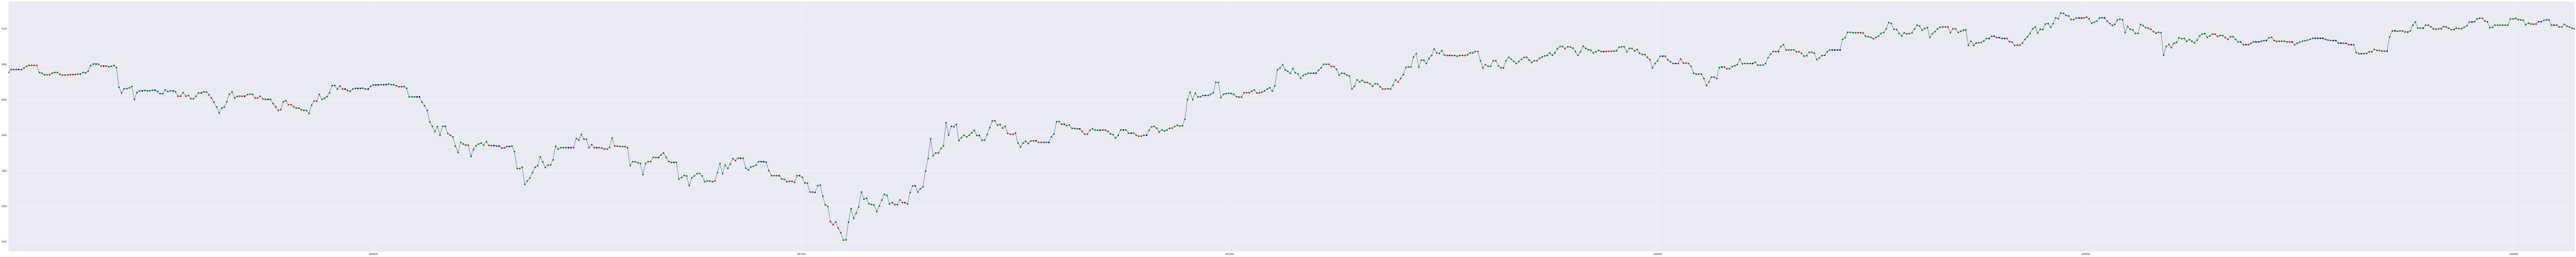

In [153]:
# See predictions on the plot 
preds = model.predict_classes(X_test)

plt.figure(figsize=[200, 20])
plt.plot(df_test['close'][-1000:])
df_test['close'][-1000:][preds[-1000:]==0].plot(style='go')
df_test['close'][-1000:][preds[-1000:]==1].plot(style='ro')
df_test['close'][-1000:][preds[-1000:]==2].plot(style='bo')

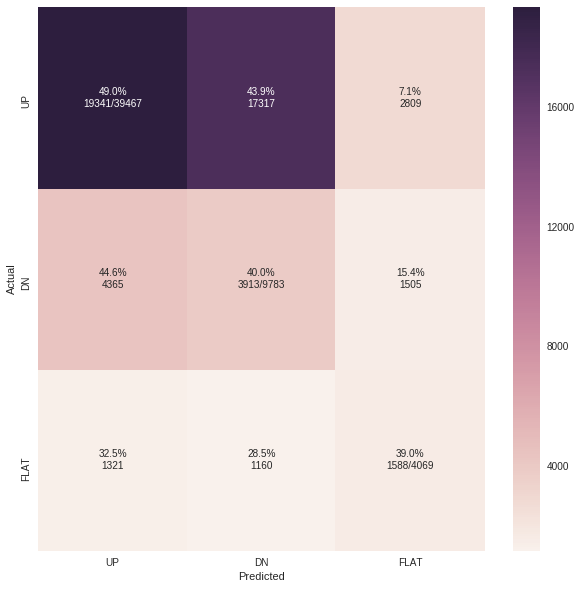

In [162]:
cm_analysis(preds, y_test.argmax(axis=1), [0, 1, 2], ymap=label_names)

### Results

    feats: [c-o, h-o, l-o, w-o]
      precision    recall  f1-score   support

         UP     0.6384    0.8045    0.7119      3371
         DN     0.6502    0.3068    0.4169      3048
       FLAT     0.7311    0.7871    0.7581      9577

    avg / total     0.6962    0.6992    0.6833     15996